# Configuração de Constantes


In [1]:
CONSTANTS = {}
# Quantas voltas serão utilizadas para prever a próxima volta
CONSTANTS['TRAILING_LAPS'] = 5
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# MinMax Scaler utilizado
# Tempos de volta da F1 giram em torno de 1:20 durante a temporada,
# com os menores valores sendo próximos de 1 minuto em pistas como a Áustria
# e os maiores valores sendo próximos de 2 minutos em pistas como Spa
# Normalizando os tempos de volta no intervalo de 0:30 a 2:00 deve melhorar
# o desempenho do modelo
CONSTANTS['scaler'] = MinMaxScaler()
CONSTANTS['scaler'].fit(np.asarray([30000, 120000]).reshape(-1, 1))

MinMaxScaler()

# Configurando conexão com Banco de Dados


In [2]:
# Conexão com o banco de dados
import mariadb
import configparser

cfg_parser = configparser.ConfigParser()
with open('database.config', 'r') as config_file:
    cfg_parser.read_file(config_file)
    host = cfg_parser.get('database', 'host')
    port = cfg_parser.get('database', 'port')
    user = cfg_parser.get('database', 'user')
    password = cfg_parser.get('database', 'password')
    name = cfg_parser.get('database', 'name')


conn = mariadb.connect(
    host=host,
    port=int(port),
    user=user,
    password=password,
    database=name
)

# Selecionando dados


## Obtendo informações da corrida


Iremos utilizar todos os tempos de volta de um determinado GP (Bahrein) de um ano (2020) para prever os tempos de volta de um determinado desse mesmo GP no ano seguinte (2021)


In [3]:
from IPython.display import display, Markdown
training_data = {}
cursor = conn.cursor()
cursor.execute("SELECT * FROM races WHERE year = 2020 AND round = 15")
training_data['race_info'] = cursor.fetchone()
training_data['race_id'] = training_data['race_info'][0]
cursor.execute("SELECT * FROM circuits WHERE id = ?", [training_data['race_info'][3]])
training_data['circuit_info'] = cursor.fetchone()
display(Markdown(f'### Corrida escolhida: {training_data["race_id"]}'))
display(Markdown(f'### {training_data["race_info"][2]}a rodada da temporada de {training_data["race_info"][1]}'))
display(Markdown(f'### Circuito: {training_data["circuit_info"][1]} em {training_data["circuit_info"][2]}, {training_data["circuit_info"][3]}'))

### Corrida escolhida: 1045

### 15a rodada da temporada de 2020

### Circuito: Bahrain International Circuit em Sakhir, Bahrain

## Selecionando amostras de tempo de volta


In [4]:
import numpy as np
# Retornando o id de todos os pilotos que registraram uma volta nessa corrida
cursor.execute("SELECT DISTINCT driver_id FROM lap_times WHERE race_id = ?", [training_data["race_id"]])
training_data['drivers_id'] = np.asarray(cursor.fetchall()).flatten()
training_data['laps_by_each_driver'] = dict()
for id in training_data['drivers_id']:
    cursor.execute("SELECT milliseconds FROM lap_times WHERE race_id = ? AND driver_id = ?", [training_data['race_id'], id])
    training_data['laps_by_each_driver'][id] = np.asarray(cursor.fetchall()).flatten()

In [5]:
training_data['inputs'] = []
training_data['outputs'] = []
for driver_index in training_data['laps_by_each_driver'].keys():
    driver_laps = training_data['laps_by_each_driver'][driver_index]
    for i in range(len(driver_laps) - CONSTANTS['TRAILING_LAPS']):
        training_data['inputs'].append(CONSTANTS['scaler'].transform(driver_laps[i:i+CONSTANTS['TRAILING_LAPS']].reshape(-1, 1)))
        training_data['outputs'].append(CONSTANTS['scaler'].transform(driver_laps[i+CONSTANTS['TRAILING_LAPS']].reshape(-1, 1)))

In [6]:
training_data['inputs'] = np.asarray(training_data['inputs'])
training_data['outputs'] = np.asarray(training_data['outputs'])

In [8]:
number_of_samples = training_data['inputs'].shape[0]
display(Markdown(f'# Serão utilizados {number_of_samples} conjuntos de {CONSTANTS["TRAILING_LAPS"]} voltas para treinar o modelo'))

# Serão utilizados 924 conjuntos de 5 voltas para treinar o modelo

# Criando rede LSTM


## Definindo a estrutura


A rede LSTM precisa ter um input=TRAILING_LAPS e um output=1


In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Modelo LSTM
trained_model = Sequential()
trained_model.add(LSTM(128, input_shape=(CONSTANTS['TRAILING_LAPS'], 1), return_sequences=True))
trained_model.add(LSTM(128))
trained_model.add(Dense(1))

2023-07-01 20:34:12.796020: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-01 20:34:12.828746: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-01 20:34:12.829254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 20:34:13.543593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-01 20:34:14.287122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

## Treinando rede neural


In [10]:
# Compilando o modelo
trained_model.compile(loss='mse', optimizer='adam')
trained_model.fit(training_data['inputs'], training_data['outputs'], epochs=5000)

Epoch 1/5000


2023-07-01 20:34:20.367125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 20:34:20.368635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 20:34:20.369828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 [==============================] - 3s 5ms/step - loss: 0.1255
Epoch 2/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 3/5000
29/29 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 4/5000
29/29 [==============================] - 0s 6ms/step - loss: 0.0137
Epoch 5/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0139
Epoch 6/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0136
Epoch 7/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0137
Epoch 8/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0136
Epoch 9/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 10/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 11/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 12/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 13/5000
29/29 [=================

# Testando rede treinada


## Selecionando corrida para teste


In [11]:
from IPython.display import display, Markdown
testing_data = {}
cursor = conn.cursor()
cursor.execute("SELECT * FROM races WHERE year = 2021 AND round = 1")
testing_data['race_info'] = cursor.fetchone()
testing_data['race_id'] = testing_data['race_info'][0]
cursor.execute("SELECT * FROM circuits WHERE id = ?", [testing_data['race_info'][3]])
testing_data['circuit_info'] = cursor.fetchone()
display(Markdown(f'### Corrida escolhida: {testing_data["race_id"]}'))
display(Markdown(f'### {testing_data["race_info"][2]}a rodada da temporada de {testing_data["race_info"][1]}'))
display(Markdown(f'### Circuito: {testing_data["circuit_info"][1]} em {testing_data["circuit_info"][2]}, {testing_data["circuit_info"][3]}'))

### Corrida escolhida: 1052

### 1a rodada da temporada de 2021

### Circuito: Bahrain International Circuit em Sakhir, Bahrain

## Selecionando amostras de tempo de volta


Ao contrário do que foi feito no caso de treinamento, no teste, iremos tentar prever o tempo de volta de apenas um piloto.


In [12]:
import numpy as np
import pandas as pd
# Retornando o id de todos os pilotos que registraram uma volta nessa corrida
cursor.execute("SELECT DISTINCT driver_id FROM lap_times WHERE race_id = ?", [testing_data["race_id"]])
testing_data['drivers_id'] = np.asarray(cursor.fetchall()).flatten()
testing_data['drivers_info'] = pd.DataFrame(columns=['Nome', 'Sobrenome'])
for id in testing_data['drivers_id']:
    cursor.execute("SELECT name, surname FROM drivers WHERE id = ?", [id])
    testing_data['drivers_info'].loc[id] = np.asarray(cursor.fetchone()).flatten()
display(testing_data['drivers_info'])

,Nome,Sobrenome
1,Lewis,Hamilton
4,Fernando,Alonso
8,Kimi,Räikkönen
20,Sebastian,Vettel
815,Sergio,Pérez
817,Daniel,Ricciardo
822,Valtteri,Bottas
830,Max,Verstappen
832,Carlos,Sainz
839,Esteban,Ocon


No caso, selecionei o piloto com ID = 20, Sebastian Vettel


In [13]:
testing_data['driver_id'] = 20
cursor.execute("SELECT milliseconds FROM lap_times WHERE race_id = ? AND driver_id = ?", [testing_data['race_id'], testing_data['driver_id']])
driver_laps = np.asarray(cursor.fetchall()).flatten()
testing_data['inputs'] = []
testing_data['outputs'] = []
for i in range(len(driver_laps) - CONSTANTS['TRAILING_LAPS']):
    testing_data['inputs'].append(CONSTANTS['scaler'].transform(driver_laps[i:i+CONSTANTS['TRAILING_LAPS']].reshape(-1, 1)))
    # Não é necessário transformar o output, pois o scaler já foi treinado com os dados de treino
    testing_data['outputs'].append(driver_laps[i+CONSTANTS['TRAILING_LAPS']].reshape(-1, 1))

In [14]:
testing_data['inputs'] = np.asarray(testing_data['inputs'])
testing_data['outputs'] = np.asarray(testing_data['outputs'])

In [15]:
number_of_samples = testing_data['inputs'].shape[0]
display(Markdown(f'# Serão utilizados {number_of_samples} conjuntos de {CONSTANTS["TRAILING_LAPS"]} voltas para testar o modelo'))

# Serão utilizados 50 conjuntos de 5 voltas para testar o modelo

## Realizando predição e comparando com resultado esperado


In [16]:
# Fazendo as previsões
predictions = trained_model.predict(testing_data['inputs'])
# Desnormalizando os dados
predictions = CONSTANTS['scaler'].inverse_transform(predictions)

2023-07-01 20:47:20.760282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 20:47:20.761710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 20:47:20.762713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 3ms/step


In [17]:
# Tornando tempos de volta em array com 1 dimensão para plotagem
testing_data['outputs'] = testing_data['outputs'].flatten()
predictions = predictions.flatten()

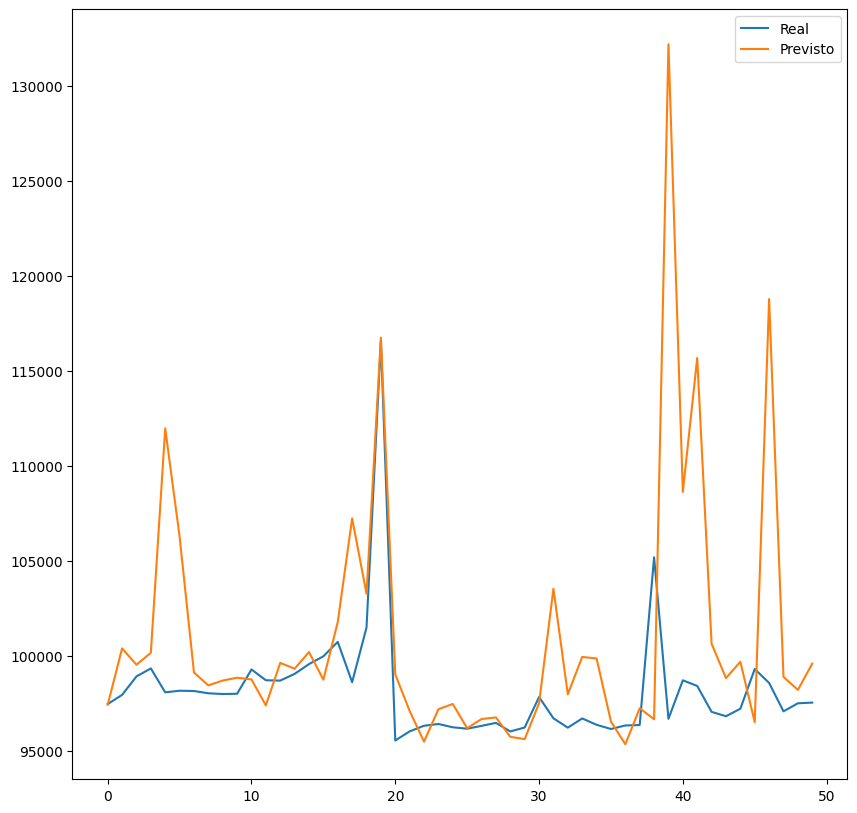

In [18]:
# Plotando gráfico comparando tempo real com tempo previsto
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(testing_data['outputs'], label='Real')
plt.plot(predictions, label='Previsto')
plt.legend()
plt.show()

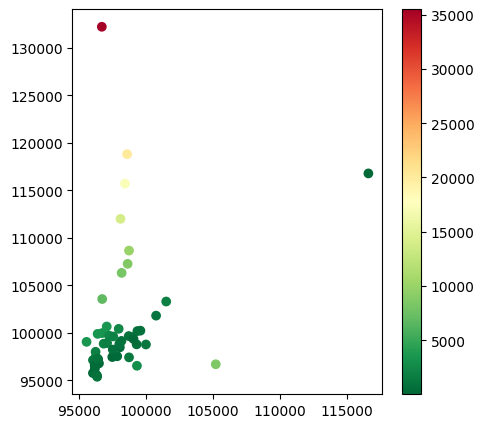

In [19]:
# Scatter plot dos tempos de volta reais e previstos
# Cor do ponto indica a diferença entre o tempo real e o tempo previsto
# Quanto mais próximo do verde, mais próximo o tempo previsto está do tempo real
# Caso o tempo previsto seja maior que o tempo real, o ponto é vermelho
differences = np.abs(testing_data['outputs'] - predictions)
plt.figure(figsize=(5, 5))
plt.scatter(testing_data['outputs'], predictions, c=differences, cmap='RdYlGn_r')
plt.colorbar()

O gráfico de cores obtido é bastante prejudicado pela presença de *outliers* no resultado final. Para melhorar a visualização, iremos ignorar os 3 piores valores e refazer a visualização.

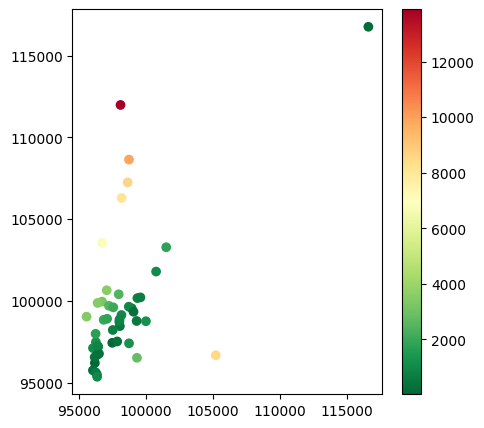

In [20]:
# Índice dos 3 maiores erros
max_three_index = differences.argsort()[-3:]
plt.figure(figsize=(5, 5))
plt.scatter(
    np.delete(testing_data['outputs'], max_three_index),
    np.delete(predictions, max_three_index),
    c=np.delete(differences, max_three_index), cmap='RdYlGn_r')
plt.colorbar()

# Conclusão

Apesar do uso de redes neurais com células LSTM (*Long Short Term Memory*) ser bastante promissor na aplicação de predição de tempos de volta para o automobilismo, ainda há muito espaço para melhora. Alguns fatores que podem melhorar a predição realizada nesse *Notebook* são:
- Lidar melhor com voltas *outliers*, como por exemplo voltas em que o piloto realizou um *pit-stop*.
- Ignorar primeira volta (por conta da largada parada)
- Aumentar o conjunto de treinamento, para abrangir mais de uma corrida